In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error

import statistics as st
import lightgbm as lgbm
from scipy.stats import norm

In [2]:
sys.path.append('../../')
import src.utils as utils

## Param

In [3]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
transactions_cols = ['playerId', 'transaction_flag', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

feature_cols3 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr', 'daysSinceLastGame'] 

In [4]:
# training lightgbm
params1 = {'objective':'mae',
           'reg_alpha': 0.14947461820098767, 
           'reg_lambda': 0.10185644384043743, 
           'n_estimators': 3633, 
           'learning_rate': 0.08046301304430488, 
           'num_leaves': 674, 
           'feature_fraction': 0.9101240539122566, 
           'bagging_fraction': 0.9884451442950513, 
           'bagging_freq': 8, 
           'min_child_samples': 51}

params2 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 80,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 22}

params3 = {'objective':'mae',
           'reg_alpha': 0.1,
           'reg_lambda': 0.1, 
           'n_estimators': 10000,
           'learning_rate': 0.1,
           'random_state': 42,
           "num_leaves": 100}

params4 = {'objective':'mae',
           'reg_alpha': 0.016468100279441976, 
           'reg_lambda': 0.09128335764019105, 
           'n_estimators': 9868, 
           'learning_rate': 0.10528150510326864, 
           'num_leaves': 157, 
           'feature_fraction': 0.5419185713426886, 
           'bagging_fraction': 0.2637405128936662, 
           'bagging_freq': 19, 
           'min_child_samples': 71}

In [5]:
EXP_NUM = 21
NFOLDS = 5

## Dir

In [6]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [7]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')

# events = pd.read_csv(TRAIN_DIR / 'events_train.csv')
# events = events.groupby(['gameDate']).sum().reset_index()


In [8]:
scores

,playerId,date,home,gamePk,teamId,jerseyNum,positionCode,battingOrder,gamesPlayedBatting,flyOuts,...,sacBuntsPitching,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index
0,112526,20180402,0,529469,140,40.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,91
1,112526,20180408,1,529546,140,40.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,97
2,112526,20180410,1,529565,140,40.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,99
3,112526,20180415,0,529640,140,40.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,104
4,112526,20180421,1,529718,140,40.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182945,685503,20210409,1,634478,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1194
182946,685503,20210414,0,634496,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1199
182947,685503,20210419,0,634536,140,35.0,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1204
182948,685503,20210425,0,634393,140,35.0,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1210


In [9]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,NaN,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [10]:
seasons_startend = seasons
seasons_startend['seasonStartDate'] = seasons_startend['seasonStartDate'].str.replace('-', '').astype(int)
seasons_startend['seasonEndDate'] = seasons_startend['seasonEndDate'].str.replace('-', '').astype(int)
seasons_startend = seasons_startend[['seasonStartDate', 'seasonEndDate']]

In [11]:
targets_train = targets[(targets['date'] >= 20210331)]

In [12]:
targets_train

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
2442285,2021-04-01,502210,0.017134,3.877565,0.003982,14.986099,1185,20210331
2442286,2021-04-01,630105,0.090707,15.558301,0.014335,1.734738,1185,20210331
2442287,2021-04-01,621532,0.000353,0.288244,0.000398,0.129224,1185,20210331
2442288,2021-04-01,468504,0.008391,5.922723,0.986705,2.365196,1185,20210331
2442289,2021-04-01,657108,1.105526,10.486583,0.070877,1.585934,1185,20210331
...,...,...,...,...,...,...,...,...
2506171,2021-05-01,451661,0.000000,0.013314,0.000000,0.625925,1215,20210430
2506172,2021-05-01,519301,0.000131,0.003329,0.000000,0.216229,1215,20210430
2506173,2021-05-01,527055,0.000000,0.019971,0.000000,0.273131,1215,20210430
2506174,2021-05-01,543484,0.000131,0.056586,0.000000,1.024240,1215,20210430


In [13]:
playerId_list = targets_train['playerId'].unique()

In [14]:
def calc_corr(df):
    # 相関係数行列を作成
    corr_mat = df.corr(method='pearson')

    # 行（列）サイズを取得
    n = corr_mat.shape[0]
    corr_ary = []

    for i in range(n):
        for j in range(i):
            if i == j:
                continue
            corr_ary.append(corr_mat.iloc[i,j])

    return corr_ary

In [15]:
def calc_probs(pid,df,temp):
    to_append=[pid,'','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    z=1
    for target in targets:
        target_prob = temp[target].tolist()
        mean = np.mean(target_prob)
        std = np.std(target_prob)
        median = st.median(target_prob)
        distribution = norm(mean, std)
        min_weight = min(target_prob)
        max_weight = max(target_prob)
        values = list(np.linspace(min_weight, max_weight))
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value)
        to_append[z]=mean
        to_append[z+1]=median
        to_append[z+2]=std
        to_append[z+3]=min_weight
        to_append[z+4]=max_weight
        to_append[z+5]=target_prob[max_index]
        to_append[z+6]=temp[target].skew()
        to_append[z+7]=temp[target].kurt()

        z=z+8
    corr_ = calc_corr(temp[['target1', 'target2', 'target3', 'target4']])
    to_append[z:] = corr_  
    df_length = len(df)
    df.loc[df_length] = to_append
    return df
    

### CREATE DATAFRAME to store probabilities
column_names = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_prob","target1_skew","target1_kurt",
                "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_prob","target2_skew","target2_kurt",
                "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_prob","target3_skew","target3_kurt",
                "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_prob","target4_skew","target4_kurt",
                'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr']
player_target_probs = pd.DataFrame(columns = column_names)
    
for pid in tqdm(playerId_list):
    temp = targets_train[targets_train['playerId'] == pid]
    player_target_stats=calc_probs(pid,player_target_probs,temp)

100%|██████████| 2061/2061 [00:45<00:00, 45.05it/s]


In [16]:
player_target_stats

,playerId,target1_mean,target1_median,target1_std,target1_min,target1_max,target1_prob,target1_skew,target1_kurt,target2_mean,...,target4_max,target4_prob,target4_skew,target4_kurt,tgt1_2_corr,tgt1_3_corr,tgt2_3_corr,tgt1_4_corr,tgt2_4_corr,tgt3_4_corr
0,502210.0,0.035258,0.010162,0.098358,0.003972,0.526284,0.004923,4.499717,21.054009,0.919837,...,26.192647,1.347459,1.787924,2.122248,0.365838,0.966925,0.303303,0.591120,0.798025,0.557092
1,630105.0,1.851187,0.321727,4.662844,0.003946,25.603476,2.889937,4.520046,22.436395,8.003389,...,19.266433,0.541118,2.754461,8.490212,-0.104008,-0.050415,0.758184,0.009365,0.480758,0.460726
2,621532.0,0.147777,0.001076,0.477206,0.000128,2.460910,0.003597,4.184232,18.542939,1.090120,...,1.665259,0.062903,2.064791,5.671338,0.140293,0.202812,0.365802,0.223219,0.895560,0.207544
3,468504.0,0.046117,0.001027,0.235568,0.000115,1.335765,0.003718,5.559476,30.935286,1.579193,...,7.059931,0.936390,3.184795,9.878932,-0.016434,-0.034419,0.495791,-0.071227,0.779922,0.278867
4,657108.0,0.888194,0.043234,1.883895,0.004996,7.304291,6.176932,2.601388,5.841344,3.955265,...,4.739336,0.386319,1.349708,1.617276,0.492365,-0.135687,-0.284340,0.192405,0.608338,-0.293661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,606944.0,0.000016,0.000000,0.000058,0.000000,0.000303,0.000000,4.289845,19.732662,0.032395,...,1.081545,1.081545,3.559596,15.202383,0.107582,0.206886,0.432962,-0.066227,0.261404,-0.039798
2057,620982.0,0.000053,0.000000,0.000214,0.000000,0.001201,0.000000,5.205614,28.050238,0.012382,...,0.121965,0.018845,1.333308,1.375743,0.044047,NaN,NaN,0.109889,0.322029,NaN
2058,462480.0,0.000008,0.000000,0.000030,0.000000,0.000131,0.000000,3.757828,13.043766,0.003493,...,0.203910,0.123635,1.207814,1.094314,-0.023063,-0.047835,0.407347,0.059401,0.126776,0.021881
2059,667465.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085977,...,0.350299,0.009643,2.585313,9.256597,NaN,NaN,-0.089247,NaN,0.192105,-0.012529


In [17]:
data_names=player_target_stats.columns.values.tolist()

In [18]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [19]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


In [20]:
# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [21]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month

In [22]:
train['gameday'] = ~train['battingOrder'].isna()*1

In [23]:
train.sort_values(by=['playerId','date'],inplace=True,ascending=True)

In [24]:
def count_consecutive_items_n_cols(df, col_name_list, output_col):
    cum_sum_list = [
        (df[col_name] != df[col_name].shift(1)).cumsum().tolist() for col_name in col_name_list
    ]
    df[output_col] = df.groupby(
        ["_".join(map(str, x)) for x in zip(*cum_sum_list)]
    ).cumcount() + 1
    return df

In [25]:
train=count_consecutive_items_n_cols(train,['playerId','gameday'],'daysSinceLastGame')
train.loc[train['gameday']==1,'daysSinceLastGame']=0

In [26]:
train_game = train[train['gameday']==1]
train_last_game = train_game[~train_game.duplicated(subset='playerId', keep='last')][['playerId', 'date']]
train_last_game.columns = ['playerId', 'lastdate']
train_player_unique = pd.DataFrame(train['playerId'].unique(), columns=['playerId'])
train_last_game = pd.merge(train_player_unique, train_last_game, on=['playerId'], how='left' )
train_last_game = train_last_game.fillna(20171231)

In [27]:
train_last_game.sort_values('lastdate')

,playerId,lastdate
856,593590,20171231.0
1995,670462,20171231.0
2000,670764,20171231.0
1765,661269,20171231.0
1932,667674,20171231.0
...,...,...
473,542932,20210430.0
1480,641856,20210430.0
1481,641857,20210430.0
483,543037,20210430.0


In [28]:
seasons_startend

,seasonStartDate,seasonEndDate
0,20170402,20171101
1,20180329,20181028
2,20190320,20191030
3,20200723,20201028
4,20210228,20211031


In [29]:
on_season_idxes = 0
for raw in seasons_startend.iloc():
    idx_ = ((train['date'].astype(int) >= raw['seasonStartDate']) & (train['date'].astype(int) <= raw['seasonEndDate'])) * 1
    on_season_idxes += idx_
#     break

In [30]:
train = train[on_season_idxes == 1].reset_index(drop=True)

In [31]:
train

,playerId,target1,target2,target3,target4,date,primaryPositionName,birthCity,DOY,mlbDebutYear,...,label_playerId,label_primaryPositionName,label_birthCity,label_teamId,label_status,annual_day,week_day,month,gameday,daysSinceLastGame
0,112526,0.031761,2.731418,0.388556,6.349412,20180329,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,87.0,3,3,0,88
1,112526,0.025906,4.622162,0.408017,11.508375,20180330,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,88.0,4,3,0,89
2,112526,0.053185,4.767842,0.275408,14.600851,20180331,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,89.0,5,3,0,90
3,112526,0.771100,63.601677,7.566316,100.000000,20180401,Pitcher,Altamira,1973,1997.0,...,969,0,588,1,3,90.0,6,4,0,91
4,112526,5.957846,22.427930,33.900803,38.857939,20180402,Pitcher,Altamira,1973,1997.0,...,969,0,588,7,0,91.0,0,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234534,685503,0.044617,1.224728,0.009437,0.737463,20210426,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,115.0,0,4,0,1
1234535,685503,0.019123,1.178880,0.013161,0.790301,20210427,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,116.0,1,4,0,2
1234536,685503,0.015799,4.323489,0.002350,0.970273,20210428,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,117.0,2,4,0,3
1234537,685503,0.018770,31.946021,0.305491,5.938273,20210429,Pitcher,Hiroshima,1992,2021.0,...,1713,0,902,7,0,118.0,3,4,0,4


In [32]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


In [33]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]
tr_idxs = []
val_idxs = []

In [34]:
tr_idx = (train['date'].astype(int) < 20200801)
val_idx = (train['date'].astype(int) >= 20200801) & (train['date'].astype(int) < 20200901)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20200901)
val_idx = (train['date'].astype(int) >= 20200901) & (train['date'].astype(int) < 20201001)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20201001)
val_idx = (train['date'].astype(int) >= 20201001) & (train['date'].astype(int) < 20201028)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210228)
val_idx = (train['date'].astype(int) >= 20210228) & (train['date'].astype(int) < 20210401)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [35]:
model1s = []
model2s = []
model3s = []
model4s = []
oof = np.zeros(train_y.shape) - 1.0
y_valids = np.zeros(train_y.shape) - 1.0

for idx in range(NFOLDS):
    
    tr_idx = tr_idxs[idx]
    val_idx = val_idxs[idx]

    x_train = train_X.loc[tr_idx].reset_index(drop=True)
    y_train = train_y.loc[tr_idx].reset_index(drop=True)
    x_valid = train_X.loc[val_idx].reset_index(drop=True)
    y_valid = train_y.loc[val_idx].reset_index(drop=True)


    oof1, model1, score1 = fit_lgbm(
        x_train[feature_cols1], y_train['target1'],
        x_valid[feature_cols1], y_valid['target1'],
        params1
    )
    oof2, model2, score2 = fit_lgbm(
        x_train[feature_cols2], y_train['target2'],
        x_valid[feature_cols2], y_valid['target2'],
        params2
    )
    oof3, model3, score3 = fit_lgbm(
        x_train[feature_cols3], y_train['target3'],
        x_valid[feature_cols3], y_valid['target3'],
        params3
    )
    oof4, model4, score4 = fit_lgbm(
        x_train[feature_cols4], y_train['target4'],
        x_valid[feature_cols4], y_valid['target4'],
        params4
    )

    score = (score1+score2+score3+score4) / 4
    print(f'score: {score}')
    
    model1s.append(model1)
    model2s.append(model2)
    model3s.append(model3)
    model4s.append(model4)
    oof[val_idx, 0] = oof1
    oof[val_idx, 1] = oof2
    oof[val_idx, 2] = oof3
    oof[val_idx, 3] = oof4
    y_valids[val_idx, 0] = y_valid['target1'].values
    y_valids[val_idx, 1] = y_valid['target2'].values
    y_valids[val_idx, 2] = y_valid['target3'].values
    y_valids[val_idx, 3] = y_valid['target4'].values
    


[LightGBM] [Warning] bagging_fraction is set=0.9884451442950513, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884451442950513
[LightGBM] [Warning] feature_fraction is set=0.9101240539122566, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9101240539122566
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.530538
Early stopping, best iteration is:
[52]	valid_0's l1: 0.53007
mae: 0.5300661102321981
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[80]	valid_0's l1: 1.64303
mae: 1.6430305588658793
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 0.60024
Early stopping, best iteration is:
[13]	valid_0's l1: 0.599835
mae: 0.5998348735731727
[LightGBM] [Warning] bagging_fraction is set=0.2637405128936662, subsample=1

In [36]:
oof_indexes = []
for i in range(NFOLDS):
    oof_indexes.extend(val_idxs[i][val_idxs[i]==True].index.to_list())

In [37]:
y_valids[val_idx, :]
mae = mean_absolute_error(y_valids[oof_indexes, :], oof[oof_indexes, :])
print("mae:", mae)

mae: 1.0068916599762827


In [38]:
oof_df = train[targets_cols]
oof_df.iloc[oof_indexes, 1:5] = oof[oof_indexes, :]

In [39]:
oof_df.iloc[oof_indexes].to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv')

In [40]:
oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [41]:
models = np.array([model1s, model2s, model3s, model4s])
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

In [42]:
weights = [0.05, 0.1, 0.15, 0.2, 0.5]

In [43]:
pred1s = 0
pred2s = 0
pred3s = 0
pred4s = 0
for i in range(NFOLDS):
    pred1 = models[0][i].predict(x_valid[feature_cols1])
    pred2 = models[1][i].predict(x_valid[feature_cols2])
    pred3 = models[2][i].predict(x_valid[feature_cols3])
    pred4 = models[3][i].predict(x_valid[feature_cols4])
    oof_valid_april = np.clip(np.array([pred1, pred2, pred3, pred4]).T, 0, 100)
    mae = mean_absolute_error(y_valid, oof_valid_april)
    print("mae:", mae)
    pred1s += pred1 * weights[i]
    pred2s += pred2 * weights[i]
    pred3s += pred3 * weights[i]
    pred4s += pred4 * weights[i]

mae: 0.9243639988545487
mae: 0.9280874388198368
mae: 0.9461138707647198
mae: 0.9205080119615825
mae: 0.9206798501283971


In [44]:
oof_valid_april = np.clip(np.array([pred1s, pred2s, pred3s, pred4s]).T, 0, 100)

In [45]:
# oof_valid_april = np.where(oof_valid_april < 0.1, 0, oof_valid_april)

In [46]:
mae = mean_absolute_error(y_valid, oof_valid_april)
print("mae:", mae)

mae: 0.915550896922551


In [47]:
0.9165205542502022
0.9163249956481581

0.9163249956481581

## EDA pred

In [63]:
importance = pd.DataFrame(model1.feature_importances_, index=feature_cols1, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[30:30].index

Index([], dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

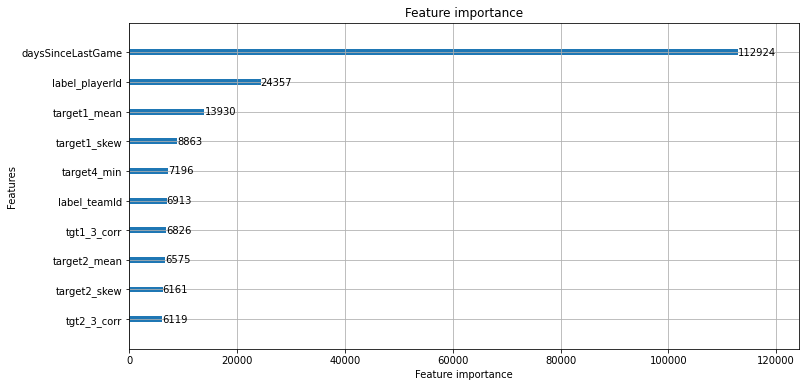

In [47]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

In [48]:
importance = pd.DataFrame(model2.feature_importances_, index=feature_cols2, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['daysSinceLastGame', 'target4_min', 'label_status', 'label_teamId',
       'target4_median', 'target2_mean', 'target2_median', 'label_playerId',
       'target2_min', 'target2_max', 'label_primaryPositionName',
       'target2_std', 'target2_skew', 'tgt1_3_corr', 'tgt1_2_corr',
       'tgt2_4_corr', 'target3_min', 'tgt1_4_corr', 'target4_std',
       'target4_skew', 'target4_mean', 'totalBases', 'target1_min',
       'target3_median', 'target4_max', 'plateAppearances', 'target1_mean',
       'battingOrder', 'target1_std', 'tgt2_3_corr'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

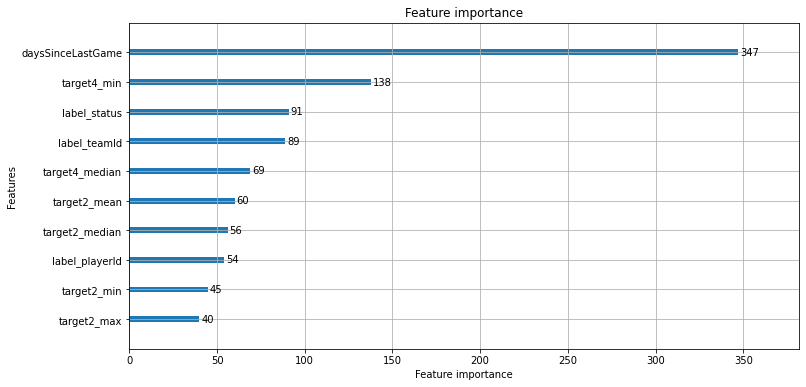

In [49]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

In [50]:
importance = pd.DataFrame(model3.feature_importances_, index=feature_cols3, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['daysSinceLastGame', 'label_playerId', 'label_teamId', 'tgt1_3_corr',
       'target4_min', 'tgt3_4_corr', 'tgt1_2_corr', 'tgt2_4_corr',
       'target4_mean', 'target2_min', 'target4_median', 'target1_skew',
       'target1_mean', 'target2_mean', 'tgt2_3_corr', 'target2_skew',
       'tgt1_4_corr', 'target2_median', 'target4_skew', 'target2_std',
       'label_primaryPositionName', 'target3_skew', 'target3_mean',
       'target2_max', 'target3_median', 'target4_std', 'target3_std',
       'label_status', 'target4_kurt', 'target1_median'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

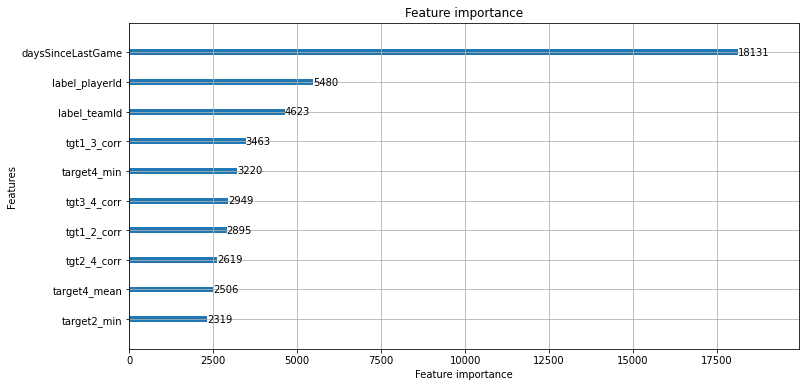

In [51]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

In [52]:
importance = pd.DataFrame(model4.feature_importances_, index=feature_cols4, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['annual_day', 'daysSinceLastGame', 'week_day', 'target4_min',
       'label_teamId', 'month', 'target4_mean', 'target4_median',
       'label_playerId', 'tgt1_2_corr', 'mlbDebutYear', 'tgt1_3_corr',
       'tgt2_3_corr', 'target2_median', 'label_birthCity', 'tgt3_4_corr',
       'weight', 'tgt1_4_corr', 'tgt2_4_corr', 'DOY', 'target4_skew',
       'target2_skew', 'target2_min', 'target3_skew', 'target2_mean',
       'target4_std', 'target4_kurt', 'target2_std', 'target1_skew',
       'target2_kurt'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

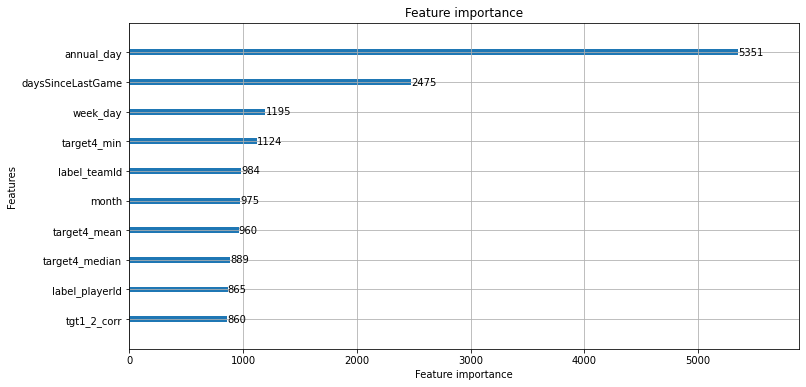

In [53]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [33]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [34]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')
test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [35]:
test_X['gameday'] = ~test_X['battingOrder'].isna()*1
test_X['date'] = test_df.index[0]
test_X = pd.merge(test_X, train_last_game, on=['playerId'], how='left')
test_X['daysSinceLastGame'] = (pd.to_datetime(test_X['date'], format="%Y%m%d") - pd.to_datetime(test_X['lastdate'], format="%Y%m%d")).dt.days
test_X.loc[test_X['gameday']==1,'daysSinceLastGame']=0

In [59]:
train_last_game = pd.merge(train_last_game, test_X[test_X['gameday']==1][['playerId','date']], on=['playerId'], how='left')
train_last_game['lastdate'].update(train_last_game['date'])
train_last_game = train_last_game[['playerId', 'lastdate']]
train_last_game

,playerId,lastdate
0,112526,20180922.0
1,134181,20180930.0
2,279571,20180930.0
3,282332,20191017.0
4,400085,20190321.0
...,...,...
2056,681911,20210426.0
2057,683232,20210426.0
2058,683734,20210426.0
2059,685493,20200927.0


In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
